## Setup, Loading Data and CDFs

In [11]:
DATA_NAME = 'standardTesting-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'gray'

In [12]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_vertical_wavelet_full_standardTesting.ipynb


In [13]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'd:\\new research\\hierarchical-bayesian-model-validation\\results\\case-studies\\standardTesting\\full\\wavelet\\vertical\\gray'

In [14]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [15]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [16]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 10,
 3: 40,
 4: 160,
 5: 640,
 6: 2560,
 7: 10240,
 8: 40960,
 9: 163840,
 10: 655360}

Running 12760 CDFs


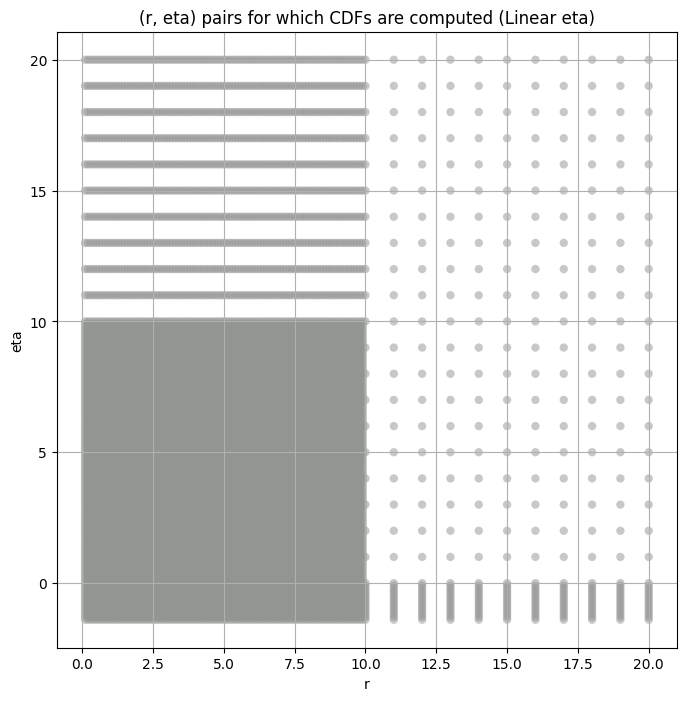

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [17]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [18]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [19]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      104440.140000  17156.541000  208108.020000  -0.478935   -1.727989   
3       44569.270000  16227.428000   89167.160000   2.537533   -1.361574   
4        9230.203000   5827.001500   13169.517000   1.865906    0.593092   
5        2238.107000   1763.183700    2774.085400   2.928785    1.469262   
6         493.924320    427.896880     565.842830   5.546187    4.264880   
7          86.401290     79.868540      93.249466   7.055166    6.091057   
8          15.715902     14.399879      17.106565   9.402432    8.193854   
9           2.729351      2.488192       2.983231  10.534738    8.633498   
10          0.528171      0.476836       0.583170  13.486254   10.583313   

       kurt_upper  total_samples  
layer                             
2        2.339415           10.0  
3        5.529101           40.0  
4        3.347688          160.0  
5        4.476616          640.0  
6        6.883670         2560.0  
7        8.109751        10240.0  
8       10.719175        40960.0  
9       13.045739       163840.0  
10      17.842747       655360.0

## Initial Grid Search and Hypothesis Test Plots

In [20]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [21]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      104440.140000  104440.140625             NaN             NaN   
3       44569.270000   44569.269531             NaN             NaN   
4        9230.203000    9230.203125     1705.306763      350.076599   
5        2238.107000    2238.106934     1100.470337      685.686340   
6         493.924320     493.924316      345.884369      273.324554   
7          86.401290      86.401291       75.107063       67.985748   
8          15.715902      15.715902       14.893235       14.262267   
9           2.729351       2.729351        2.642460        2.580198   
10          0.528171       0.528171        0.507265        0.492914   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3                 NaN              NaN              NaN              NaN   
4            1.422925              NaN              NaN              NaN   
5          460.896545       306.107330       129.900650        50.078625   
6          222.208221       186.758347       136.335480       102.381660   
7           62.153954        57.156860        49.437664        43.569221   
8           13.718467        13.236310        12.403774        11.691115   
9            2.526210         2.477988         2.393489         2.319792   
10           0.480753         0.470081         0.451702         0.435957   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3                  NaN              NaN              NaN              NaN  
4                  NaN              NaN              NaN              NaN  
5            13.154905         0.929515              NaN              NaN  
6            78.283134        60.383854        47.404991        22.718555  
7            38.738316        34.693275        31.347115        23.764868  
8            11.064066        10.506679        10.005114         8.768734  
9             2.253113         2.191995         2.135688         1.988352  
10            0.421858         0.409111         0.397537         0.367189

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.21550039197557552 104440.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 10, Without approximation : 10.0


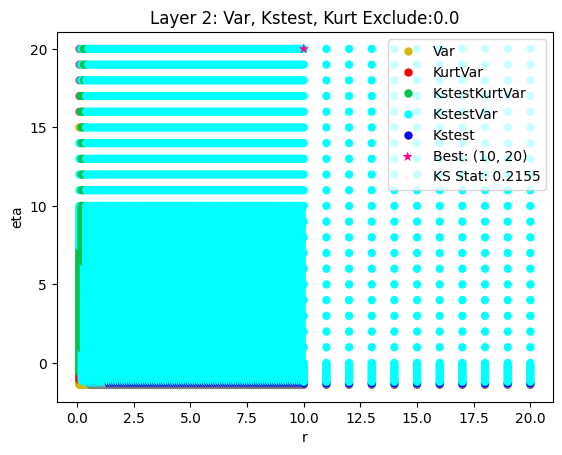

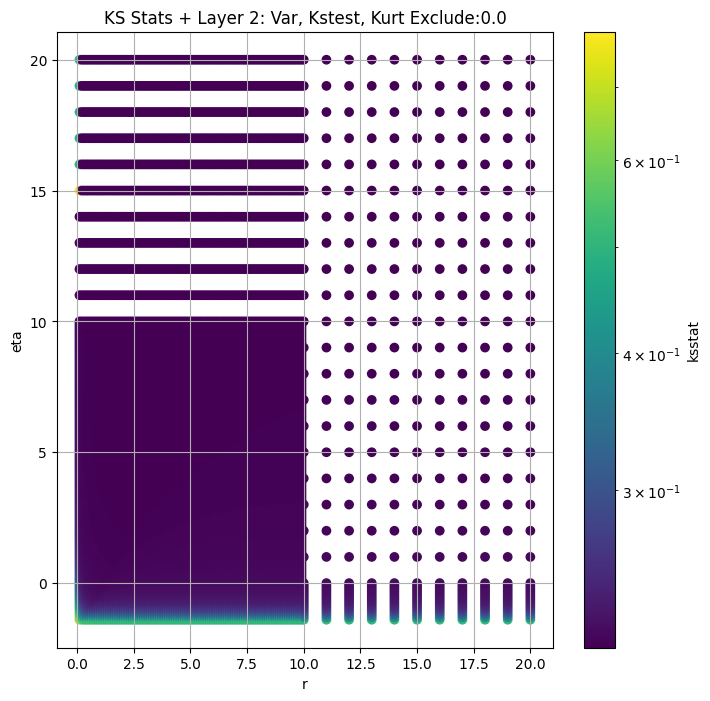

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.12393249939024545 44569.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 nan nan
Number of samples: 40, Without approximation : 40.0


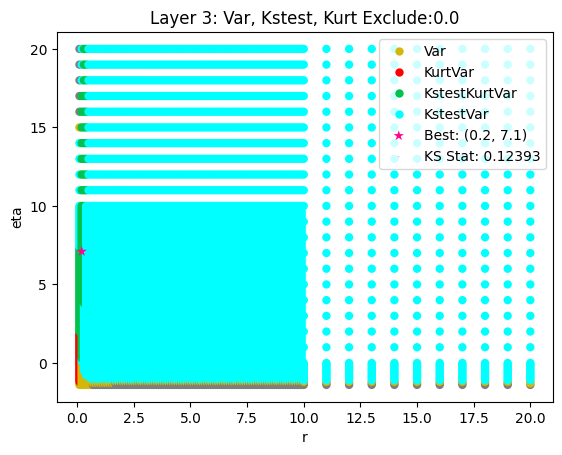

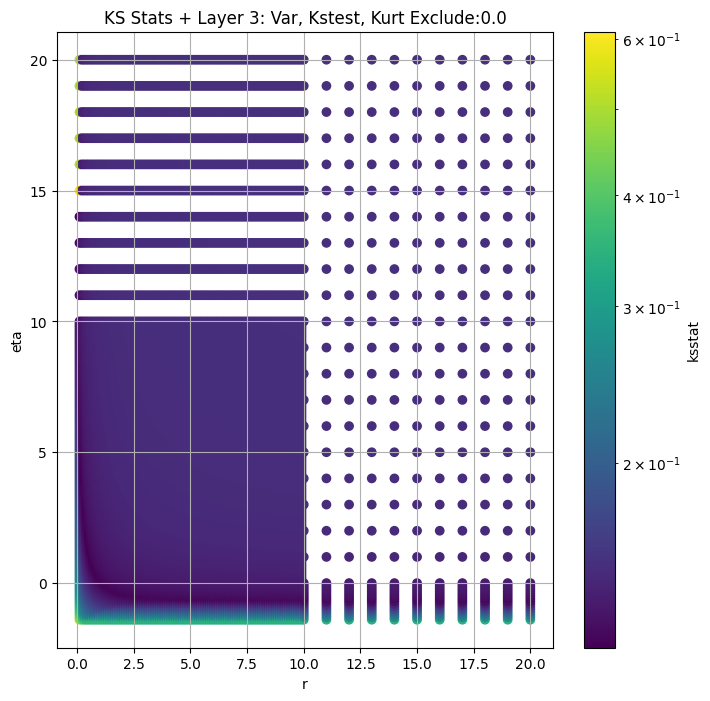

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.032590424991189915 9230.203


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.17292263834798416 1705.3068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.30932414482424864 350.0766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.462037805262035 1.4229248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 nan nan
Number of samples: 160, Without approximation : 160.0


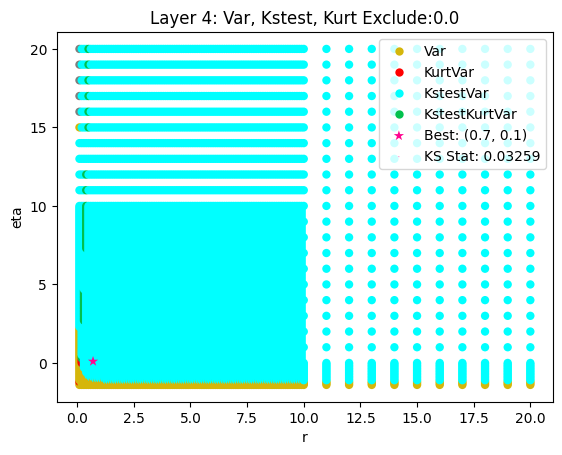

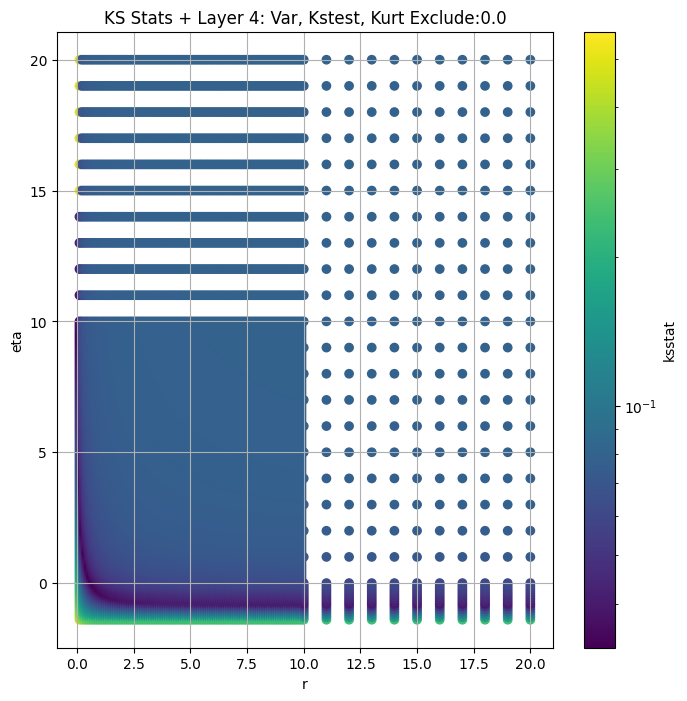

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.025769982324452045 2238.107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.05604473139718308 1100.4703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.09186274206330804 685.68634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.12747321299709635 460.89655


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.15330499670709102 306.10733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.21704209063285582 129.90065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.28497364173397843 50.078625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.36335257821123335 13.154905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.45612171197624796 0.9295155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 nan nan
Number of samples: 640, Without approximation : 640.0


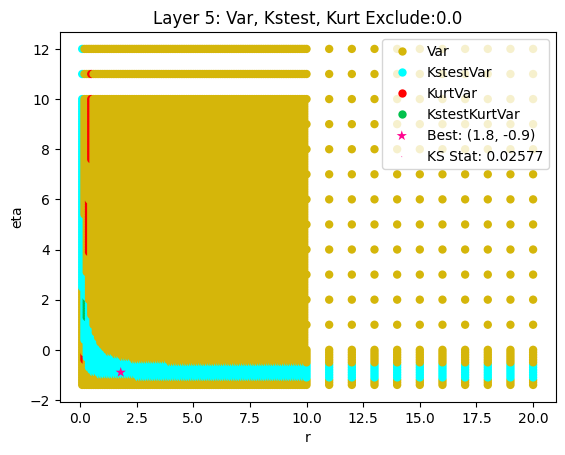

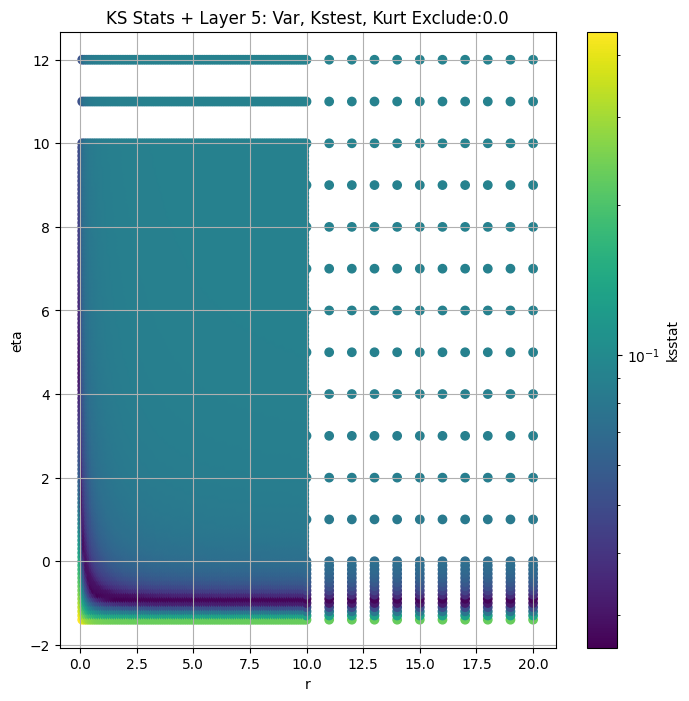

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011078582591009419 493.92432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.02002588584821726 345.88437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.030464924846445283 273.32455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.03979931756431847 222.20822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.049141759011842784 186.75835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.06703540947486773 136.33548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.08521949372916032 102.38166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.10344632548604668 78.283134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.11952895343666237 60.383854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.1363960215367367 47.40499


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.18883609710624738 22.718555
Number of samples: 2560, Without approximation : 2560.0


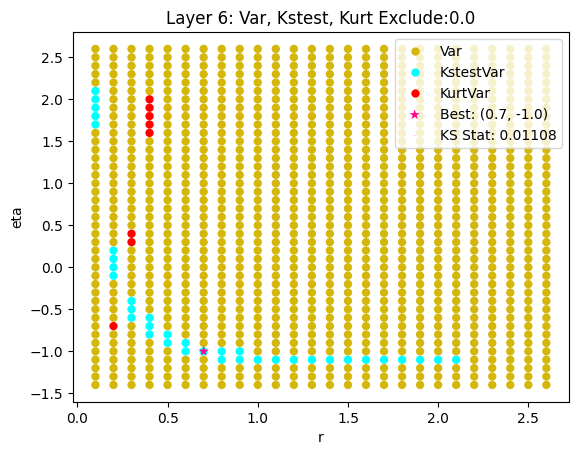

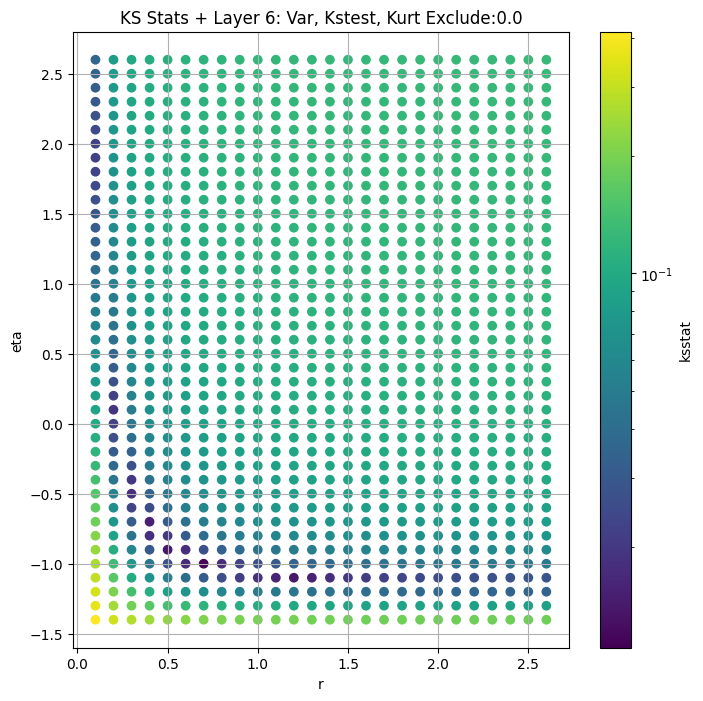

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.01754528429253155 86.40129


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.016890084025918073 75.10706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.016825411721167638 67.98575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.01723227280646622 62.153954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.018396346885001802 57.15686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.02269746147292684 49.437664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.028268887725897196 43.56922


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.033536635994756425 38.738316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.038093289355259796 34.693275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.04258892554001237 31.347115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.05774143721361935 23.764868
Number of samples: 10240, Without approximation : 10240.0


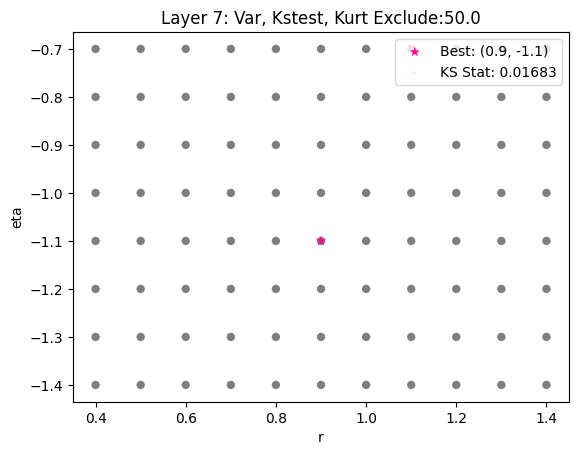

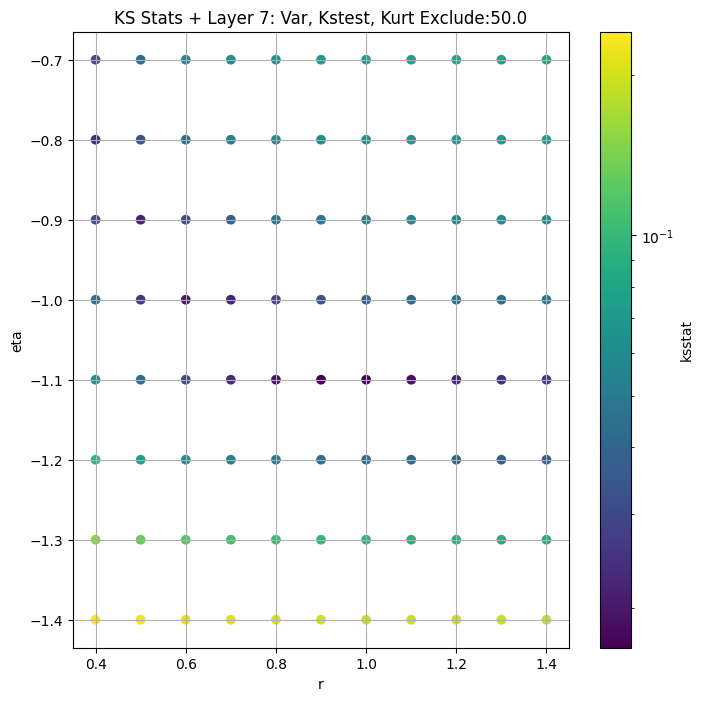

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.011638681292367503 15.715902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.013545811403767094 14.893235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.014933029378305651 14.262267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01497873236755276 13.718467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01307996168293607 13.23631


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.011231604846885582 12.403774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.014178201542703217 11.691115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011669937047496248 11.064066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.013173128545809494 10.506679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01421782240794562 10.005114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.017682722461268625 8.768734
Number of samples: 40960, Without approximation : 40960.0


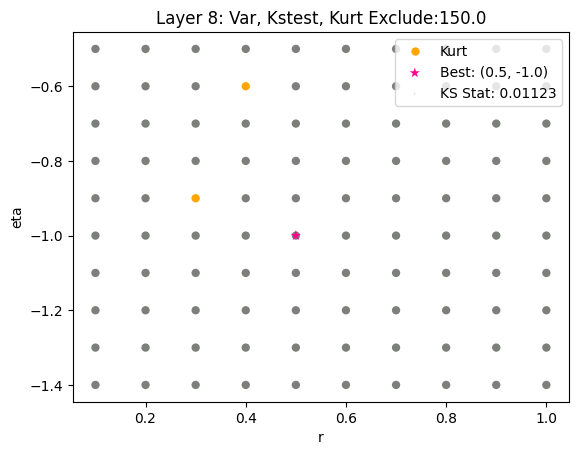

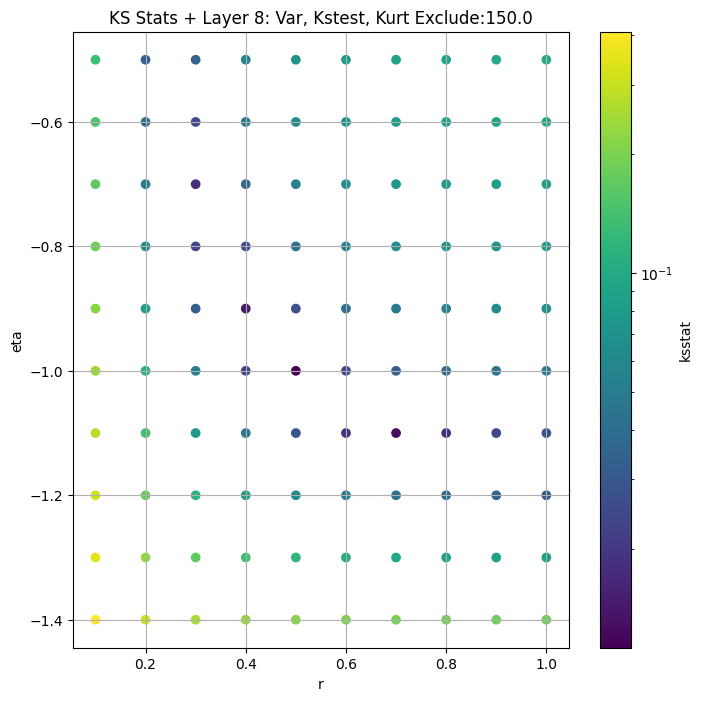

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.011774107982185533 2.7293506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.011038120611805535 2.6424599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.01217378093441579 2.5801978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013173479971596791 2.5262098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.014078513887003652 2.4779875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.015692864414960317 2.393489


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.015332547940619778 2.3197918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.013501729893091008 2.2531133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01350491537979892 2.1919954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.012324576412694688 2.1356878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.0155061078728429 1.9883516
Number of samples: 100000, Without approximation : 163840.0


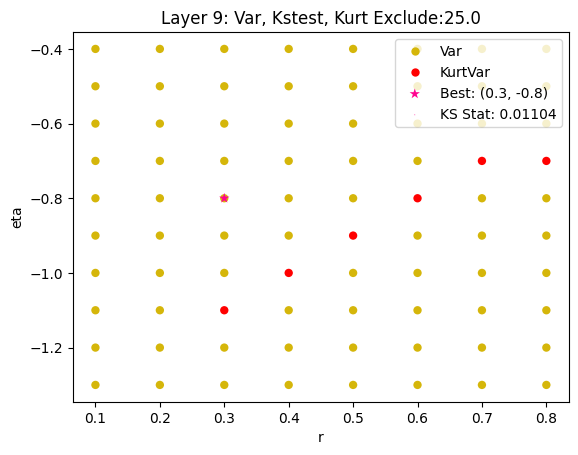

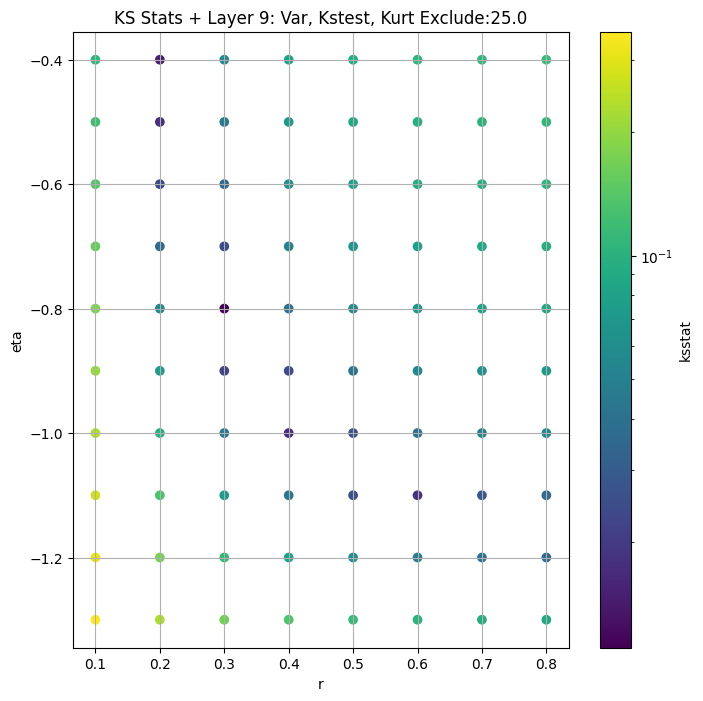

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.02314200749514167 0.5281712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.022638994896542253 0.5072651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.022818770409161193 0.4929136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.023001610368041603 0.48075253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.02320128572158542 0.47008055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.02438221745022523 0.4517022


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.023480761520854876 0.43595707


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.023181933413504552 0.42185754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.023375508709986337 0.40911138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.02360475330876699 0.39753687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.02415418324922286 0.367189
Number of samples: 100000, Without approximation : 655360.0


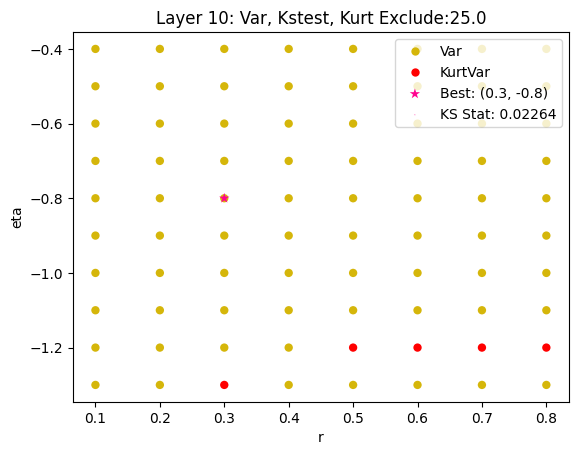

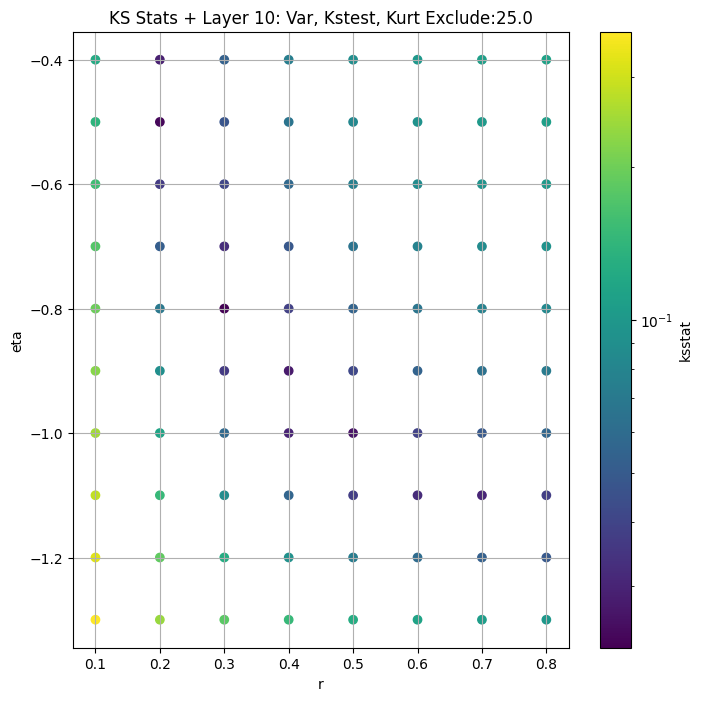

obs_var     var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      104440.140000  17156.541000  208108.020000  -0.478935   -1.727989   
3       44569.270000  16227.428000   89167.160000   2.537533   -1.361574   
4        9230.203000   5827.001500   13169.517000   1.865906    0.593092   
5        2238.107000   1763.183700    2774.085400   2.928785    1.469262   
6         493.924320    427.896880     565.842830   5.546187    4.264880   
7          86.401290     79.868540      93.249466   7.055166    6.091057   
8          15.715902     14.399879      17.106565   9.402432    8.193854   
9           2.729351      2.488192       2.983231  10.534738    8.633498   
10          0.528171      0.476836       0.583170  13.486254   10.583313   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.339415           10.0             0.215500       10.0         20.0   
3        5.529101           40.0             0.123932        0.2          7.1   
4        3.347688          160.0             0.032590        0.7          0.1   
5        4.476616          640.0             0.025770        1.8         -0.9   
6        6.883670         2560.0             0.011079        0.7         -1.0   
7        8.109751        10240.0             0.016825        0.9         -1.1   
8       10.719175        40960.0             0.011232        0.5         -1.0   
9       13.045739       163840.0             0.011038        0.3         -0.8   
10      17.842747       655360.0             0.022639        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       98908.789681                     0.0       104440.140000   
3           0.000242                     0.0        44569.270000   
4        2517.777265                     0.0         9230.203000   
5        5563.165640                     0.0         2238.107000   
6         589.524470                     0.0          493.924320   
7         152.356211                    50.0           67.985750   
8           6.201887                   150.0           12.403774   
9           0.045828                    25.0            2.642460   
10          0.008797                    25.0            0.507265   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.409246  
3                     0.210115  
4                     0.106268  
5                     0.053416  
6                     0.026776  
7                     0.013405  
8                     0.006706  
9                     0.003354  
10                    0.001677

In [22]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [23]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/5 [00:00<?, ?it/s]

Finding Minimum after computing 5 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Finding Minimum after computing 5 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Finding Minimum after computing 5 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Finding Minimum after computing 5 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Finding Minimum after computing 5 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.21550039197557552, var: 104440.140625
Number of samples: 10, Without approximation : 10.0


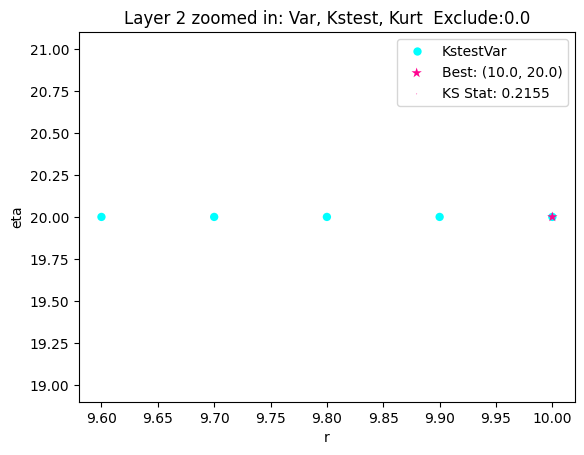

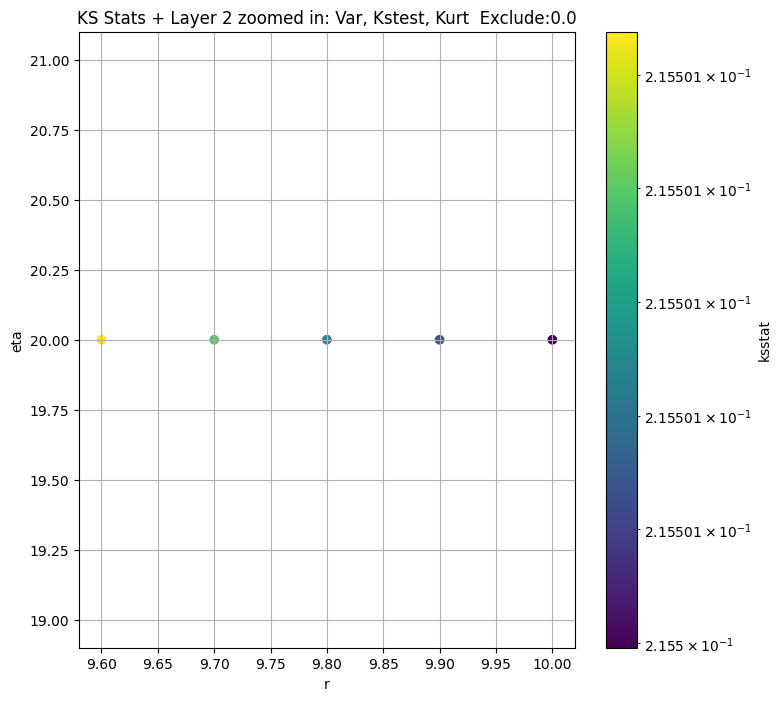

Layer 3


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 50 = 50, ksstat: nan, var: nan


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 25 = 25, ksstat: nan, var: nan


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.12378371666303212, var: 44569.26953125
Number of samples: 40, Without approximation : 40.0


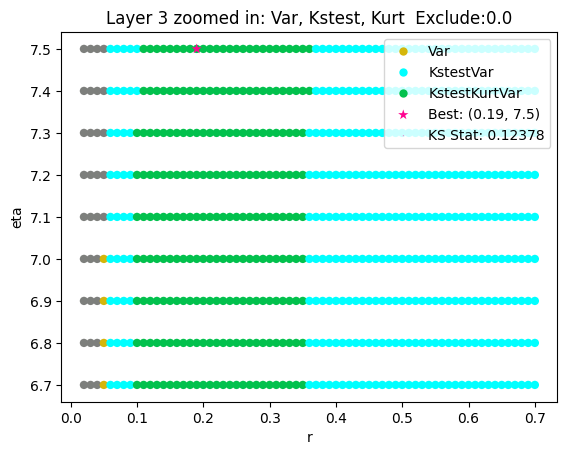

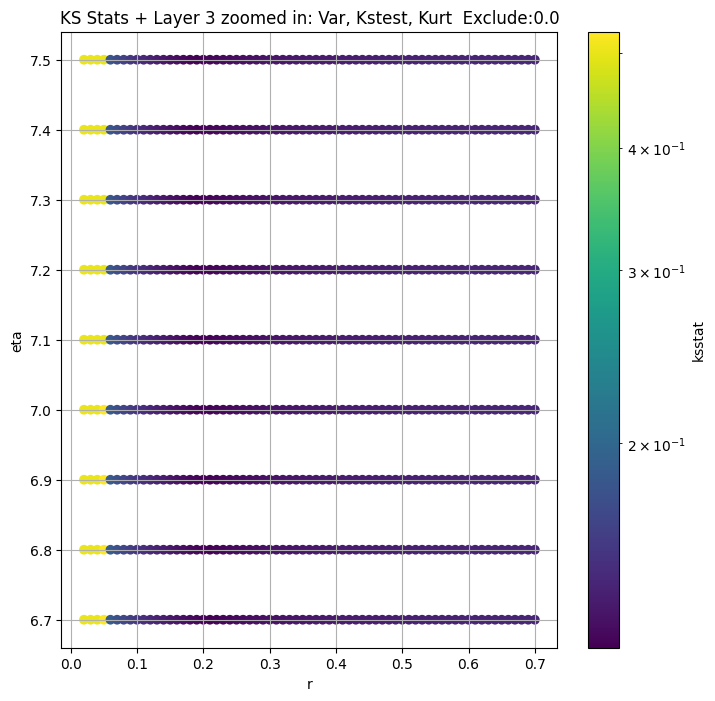

Layer 4


  0%|          | 0/1260 [00:00<?, ?it/s]

Finding Minimum after computing 1260 CDFs
layer 4, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/1260 [00:00<?, ?it/s]

Finding Minimum after computing 1260 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.46710730277833945, var: 1.4229247570037842


  0%|          | 0/1260 [00:00<?, ?it/s]

Finding Minimum after computing 1260 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.31260893562171765, var: 350.07659912109375


  0%|          | 0/1260 [00:00<?, ?it/s]

Finding Minimum after computing 1260 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.17891605219070272, var: 1705.3067626953125


  0%|          | 0/1260 [00:00<?, ?it/s]

Finding Minimum after computing 1260 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.03210741979236631, var: 9230.203125
Number of samples: 160, Without approximation : 160.0


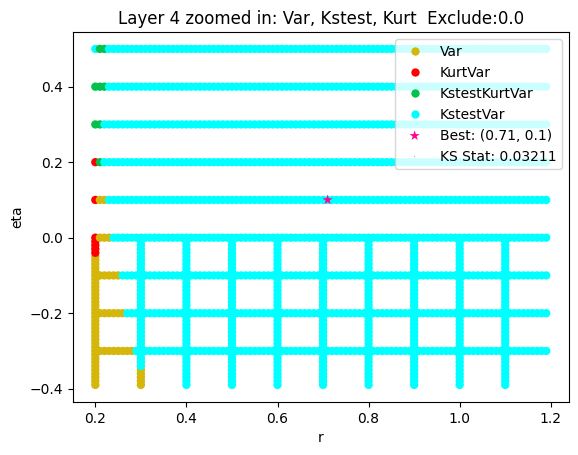

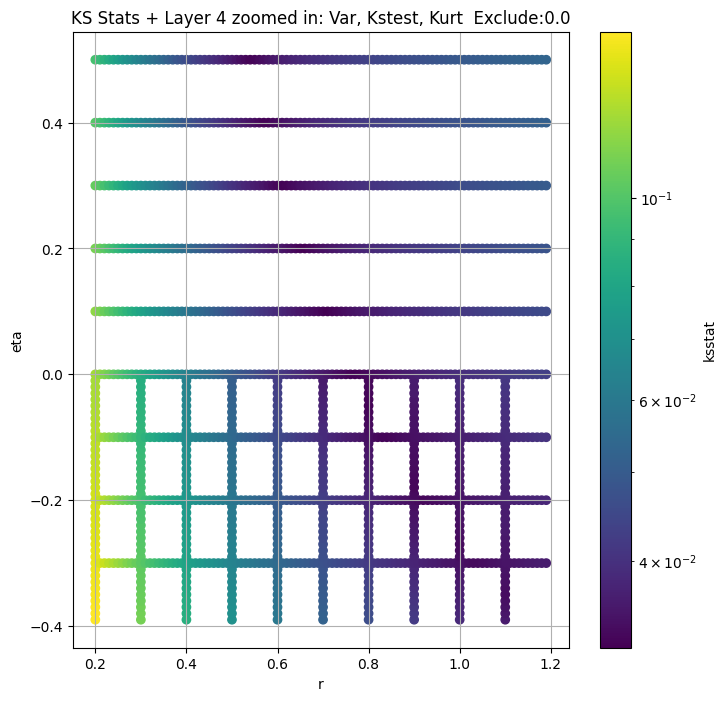

Layer 5


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.15437479357074216, var: 306.1073303222656


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.12923575174283866, var: 460.89654541015625


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.09841112515614917, var: 685.6863403320312


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.059359960948116394, var: 1100.4703369140625


  0%|          | 0/1360 [00:00<?, ?it/s]

Finding Minimum after computing 1360 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.025742130569095245, var: 2238.10693359375
Number of samples: 640, Without approximation : 640.0


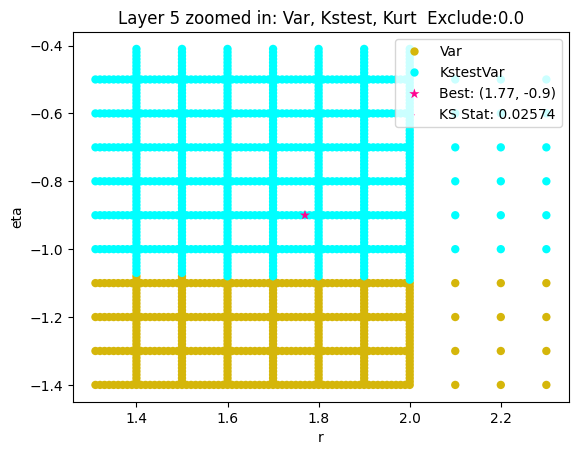

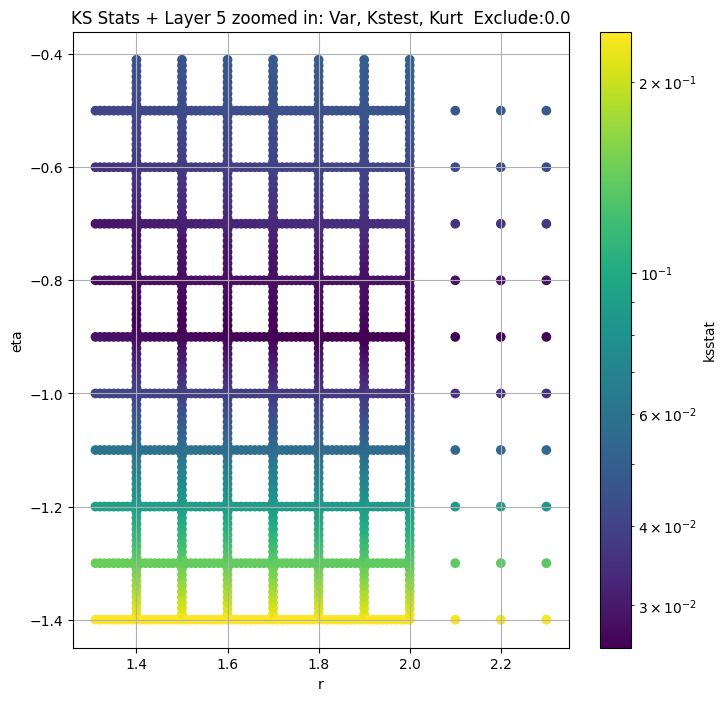

Layer 6


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.05259125179374994, var: 186.7583465576172


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.04316965427670557, var: 222.20822143554688


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.03306670045682725, var: 273.3245544433594


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.022956367608654236, var: 345.8843688964844


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.010915282107978076, var: 493.92431640625
Number of samples: 2560, Without approximation : 2560.0


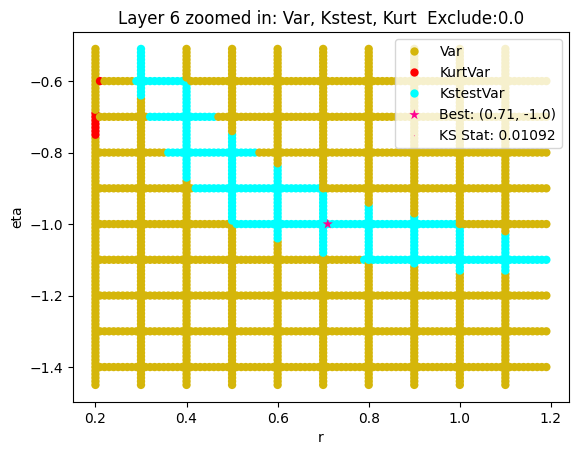

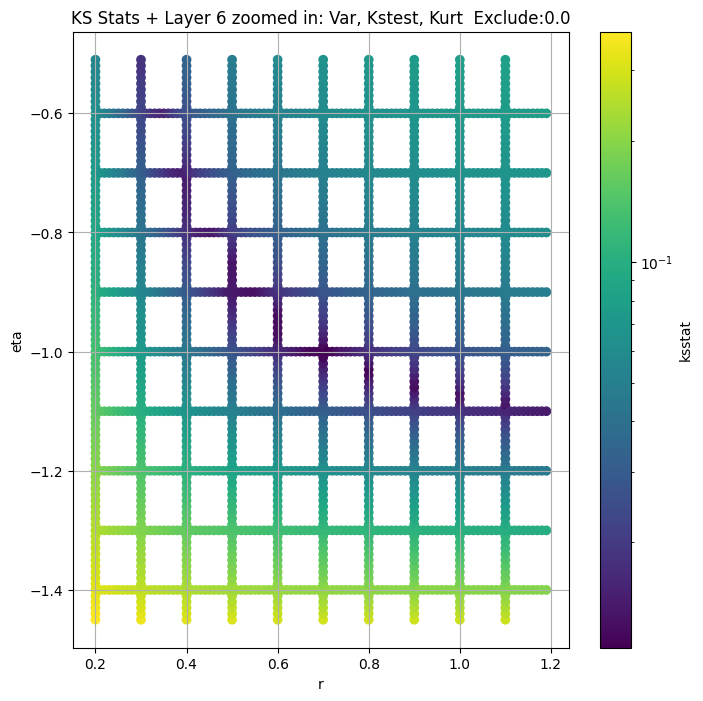

Layer 7


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.025070641961765228, var: 49.43766403198242


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.022006161786949696, var: 53.0147705078125


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.018751381672636125, var: 57.1568603515625


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.016181440074716336, var: 62.153953552246094


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.016504485623123955, var: 67.98574829101562


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.01646968671150173, var: 75.10706329345703


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.01667257795194388, var: 86.40129089355469
Number of samples: 10240, Without approximation : 10240.0


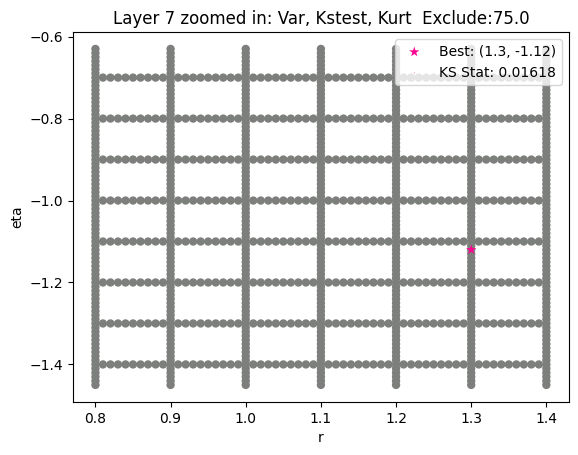

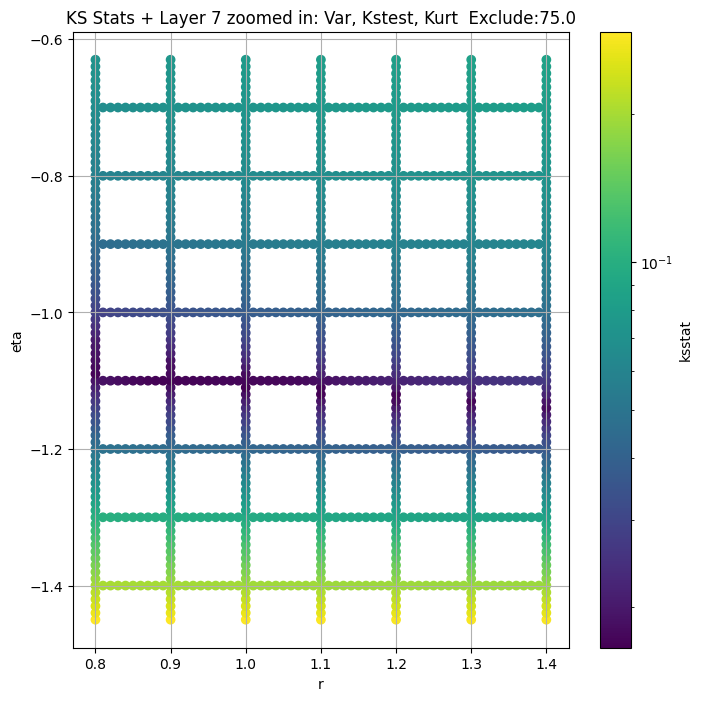

Layer 8


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.011612050159088505, var: 11.064065933227539


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.01114665468258598, var: 11.366827964782715


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.011400611366330526, var: 11.691115379333496


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.010581892029880913, var: 12.036036491394043


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.010345894276926781, var: 12.40377426147461


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.0101361541028228, var: 12.801976203918457


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.009182832592920576, var: 13.236310005187988


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.009127419001525694, var: 13.718466758728027


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.008762946234921187, var: 14.262267112731934
Number of samples: 40960, Without approximation : 40960.0


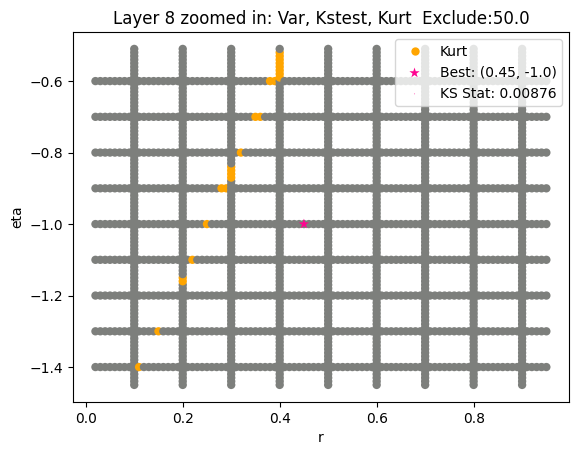

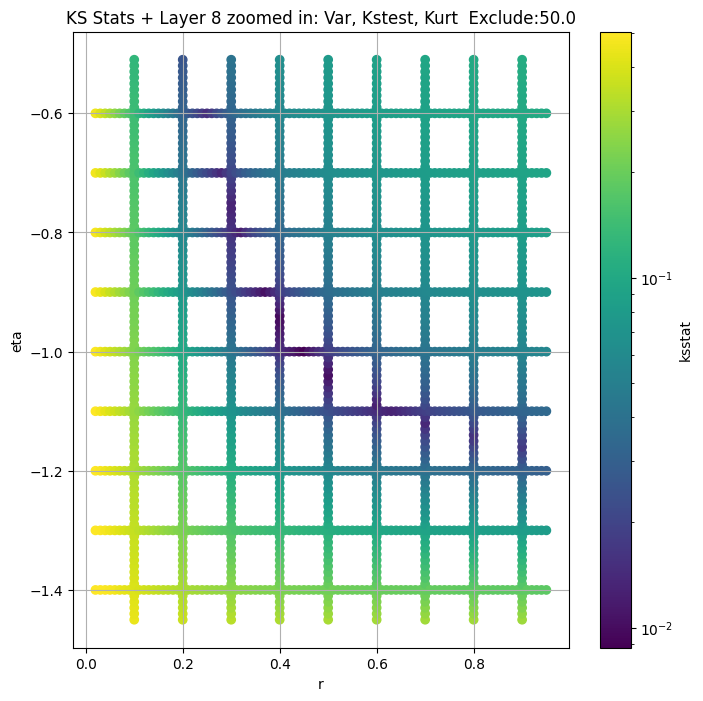

Layer 9


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.010795926554605595, var: 2.4340481758117676


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.011001896437300318, var: 2.47798752784729


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.010359973995189398, var: 2.526209831237793


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.010419137534921186, var: 2.580197811126709


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.010446436786367586, var: 2.6424598693847656


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.010235514597514539, var: 2.7293505668640137
Number of samples: 100000, Without approximation : 163840.0


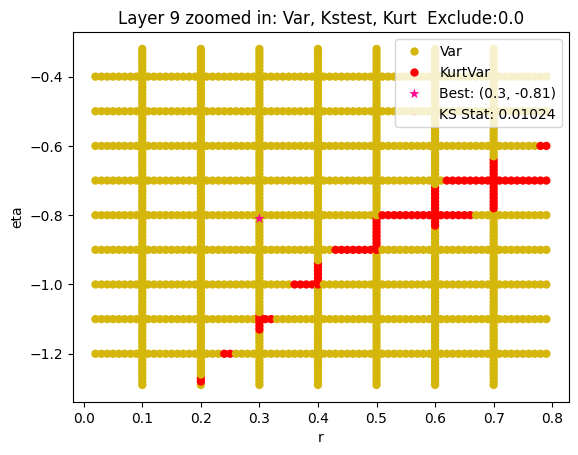

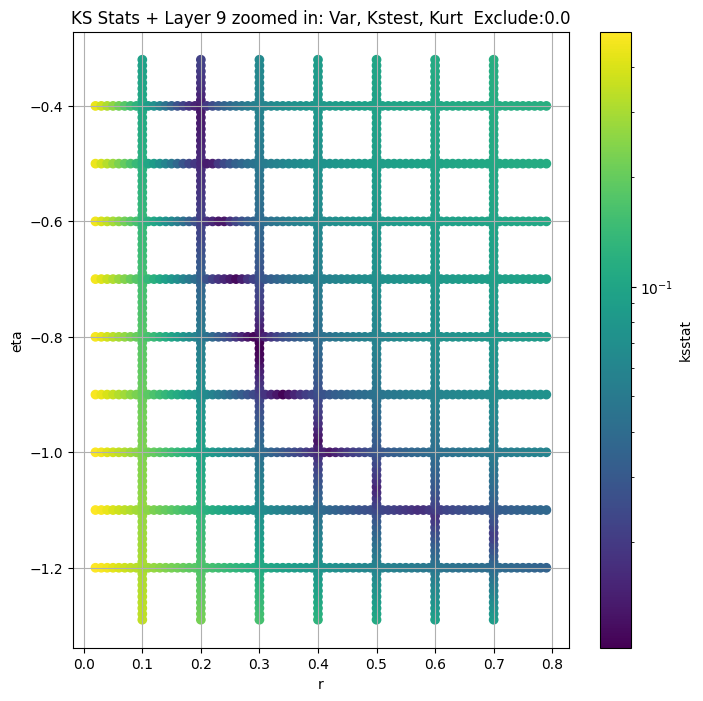

Layer 10


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 100 = 125, ksstat: 0.022520884144944076, var: 0.4604925513267517


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 75 = 100, ksstat: 0.0226365647446492, var: 0.47008055448532104


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 50 = 75, ksstat: 0.022138377184896196, var: 0.48075252771377563


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 25 = 50, ksstat: 0.022706961597070197, var: 0.4929136037826538


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 0 = 25, ksstat: 0.022638994896542253, var: 0.5072650909423828


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + -25 = 0, ksstat: 0.022370228129355074, var: 0.528171181678772
Number of samples: 100000, Without approximation : 655360.0


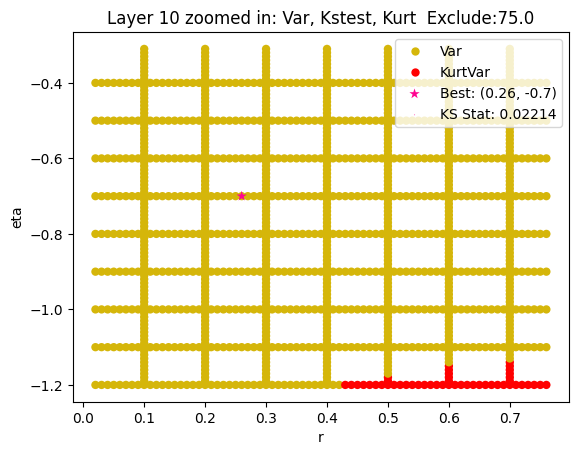

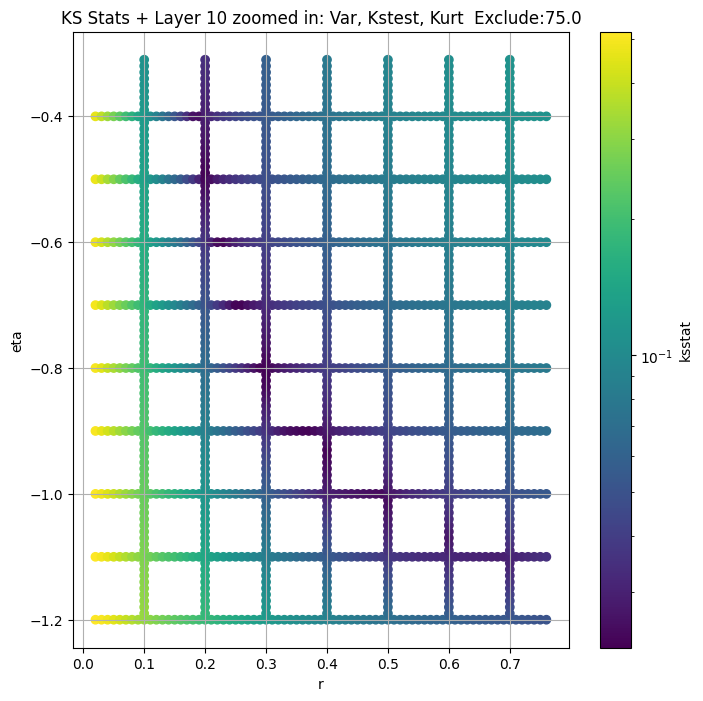

obs_var     var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      104440.140000  17156.541000  208108.020000  -0.478935   -1.727989   
3       44569.270000  16227.428000   89167.160000   2.537533   -1.361574   
4        9230.203000   5827.001500   13169.517000   1.865906    0.593092   
5        2238.107000   1763.183700    2774.085400   2.928785    1.469262   
6         493.924320    427.896880     565.842830   5.546187    4.264880   
7          86.401290     79.868540      93.249466   7.055166    6.091057   
8          15.715902     14.399879      17.106565   9.402432    8.193854   
9           2.729351      2.488192       2.983231  10.534738    8.633498   
10          0.528171      0.476836       0.583170  13.486254   10.583313   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.339415           10.0             0.215500       10.0         20.0   
3        5.529101           40.0             0.123932        0.2          7.1   
4        3.347688          160.0             0.032590        0.7          0.1   
5        4.476616          640.0             0.025770        1.8         -0.9   
6        6.883670         2560.0             0.011079        0.7         -1.0   
7        8.109751        10240.0             0.016825        0.9         -1.1   
8       10.719175        40960.0             0.011232        0.5         -1.0   
9       13.045739       163840.0             0.011038        0.3         -0.8   
10      17.842747       655360.0             0.022639        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       98908.789681                     0.0       104440.140000   
3           0.000242                     0.0        44569.269531   
4        2517.777265                     0.0         9230.203125   
5        5563.165640                     0.0         2238.106934   
6         589.524470                     0.0          493.924316   
7         152.356211                    50.0           62.153954   
8           6.201887                   150.0           14.262267   
9           0.045828                    25.0            2.729351   
10          0.008797                    25.0            0.480753   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.409246          0.215500   10.00     20.00   
3                     0.210115          0.123784    0.19      7.50   
4                     0.106268          0.032107    0.71      0.10   
5                     0.053416          0.025742    1.77     -0.90   
6                     0.026776          0.010915    0.71     -1.00   
7                     0.013405          0.016181    1.30     -1.12   
8                     0.006706          0.008763    0.45     -1.00   
9                     0.003354          0.010236    0.30     -0.81   
10                    0.001677          0.022138    0.26     -0.70   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      98908.789681                  0.0           40  
3          0.000054                  0.0          112  
4       2625.994177                  0.0         1822  
5       5529.568379                  0.0         2733  
6        605.758394                  0.0        15565  
7        197.397408                 75.0         7290  
8          4.861448                 50.0        23040  
9          0.048990                  0.0        17280  
10         0.001657                 75.0         3840

In [24]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

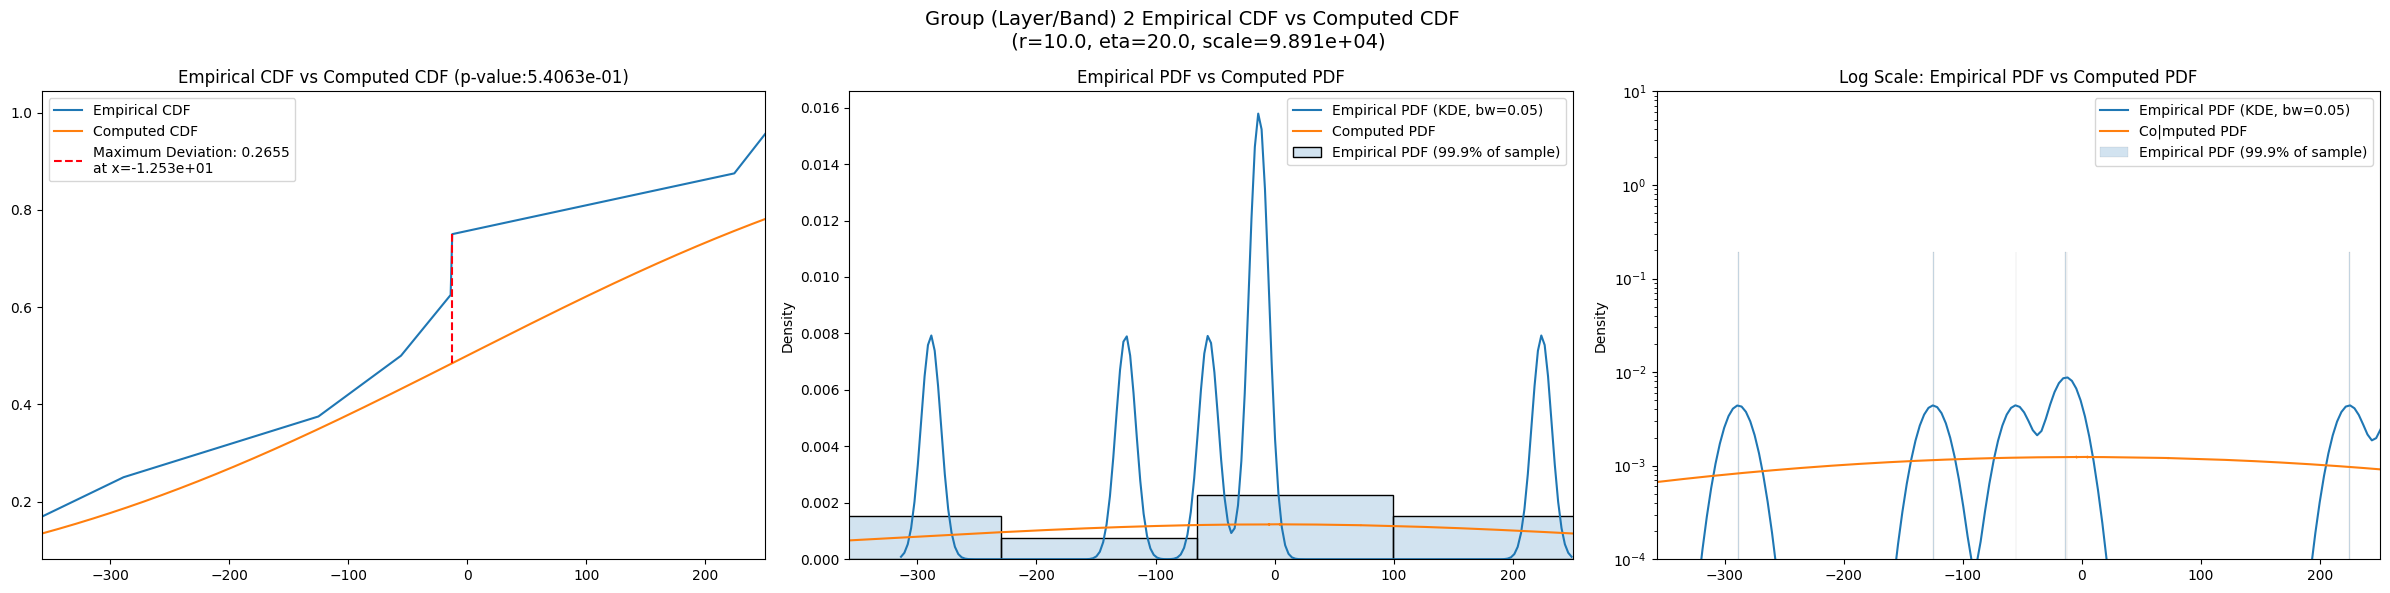

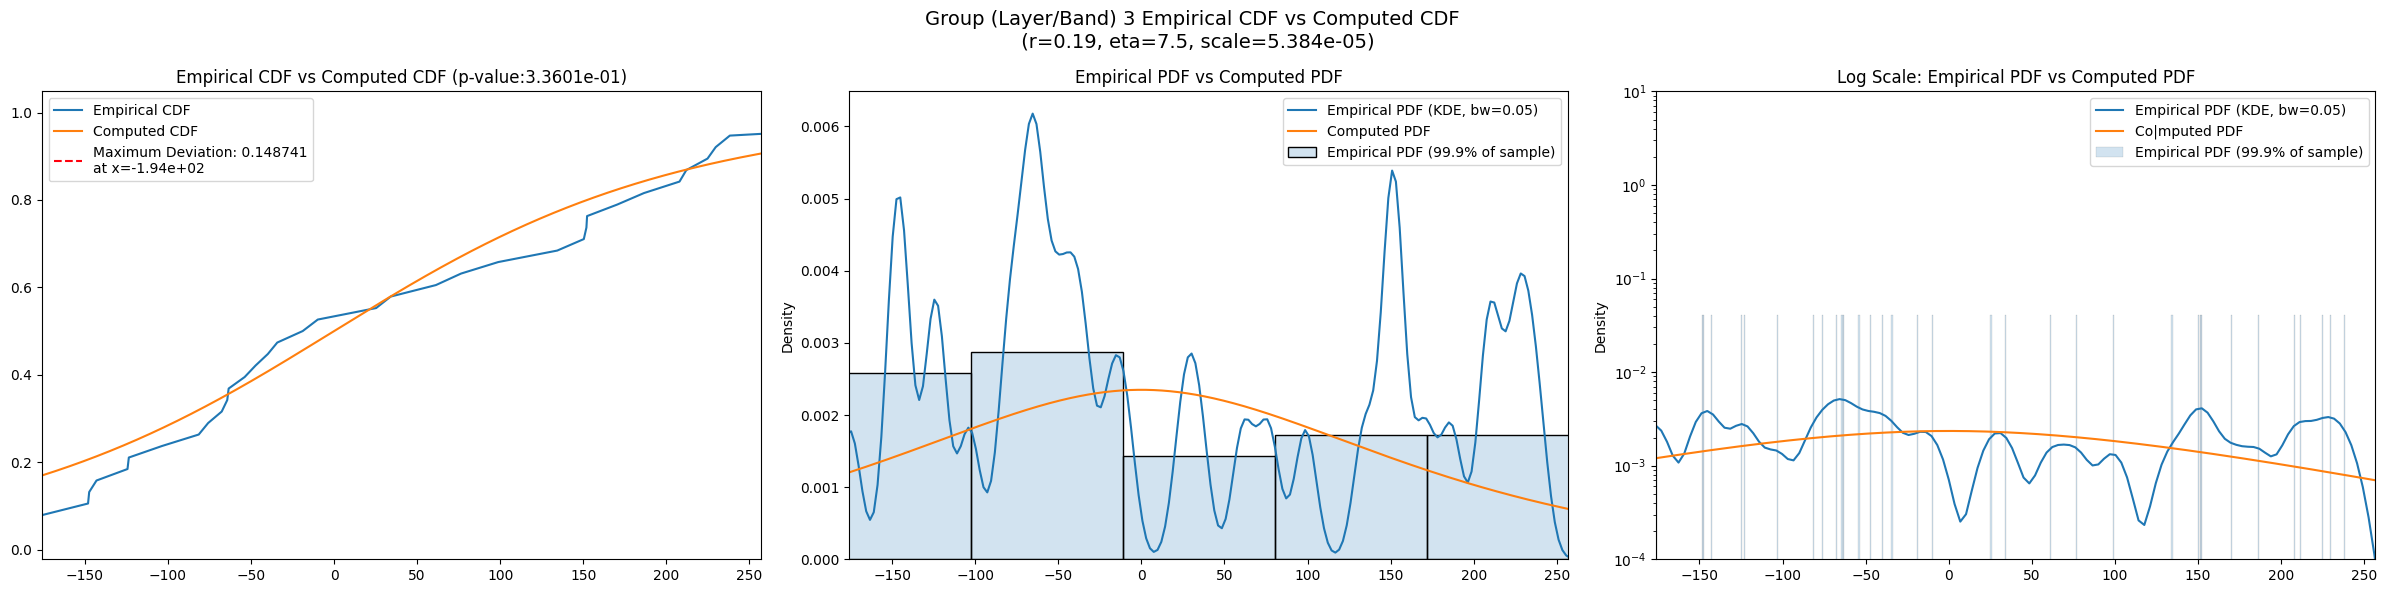

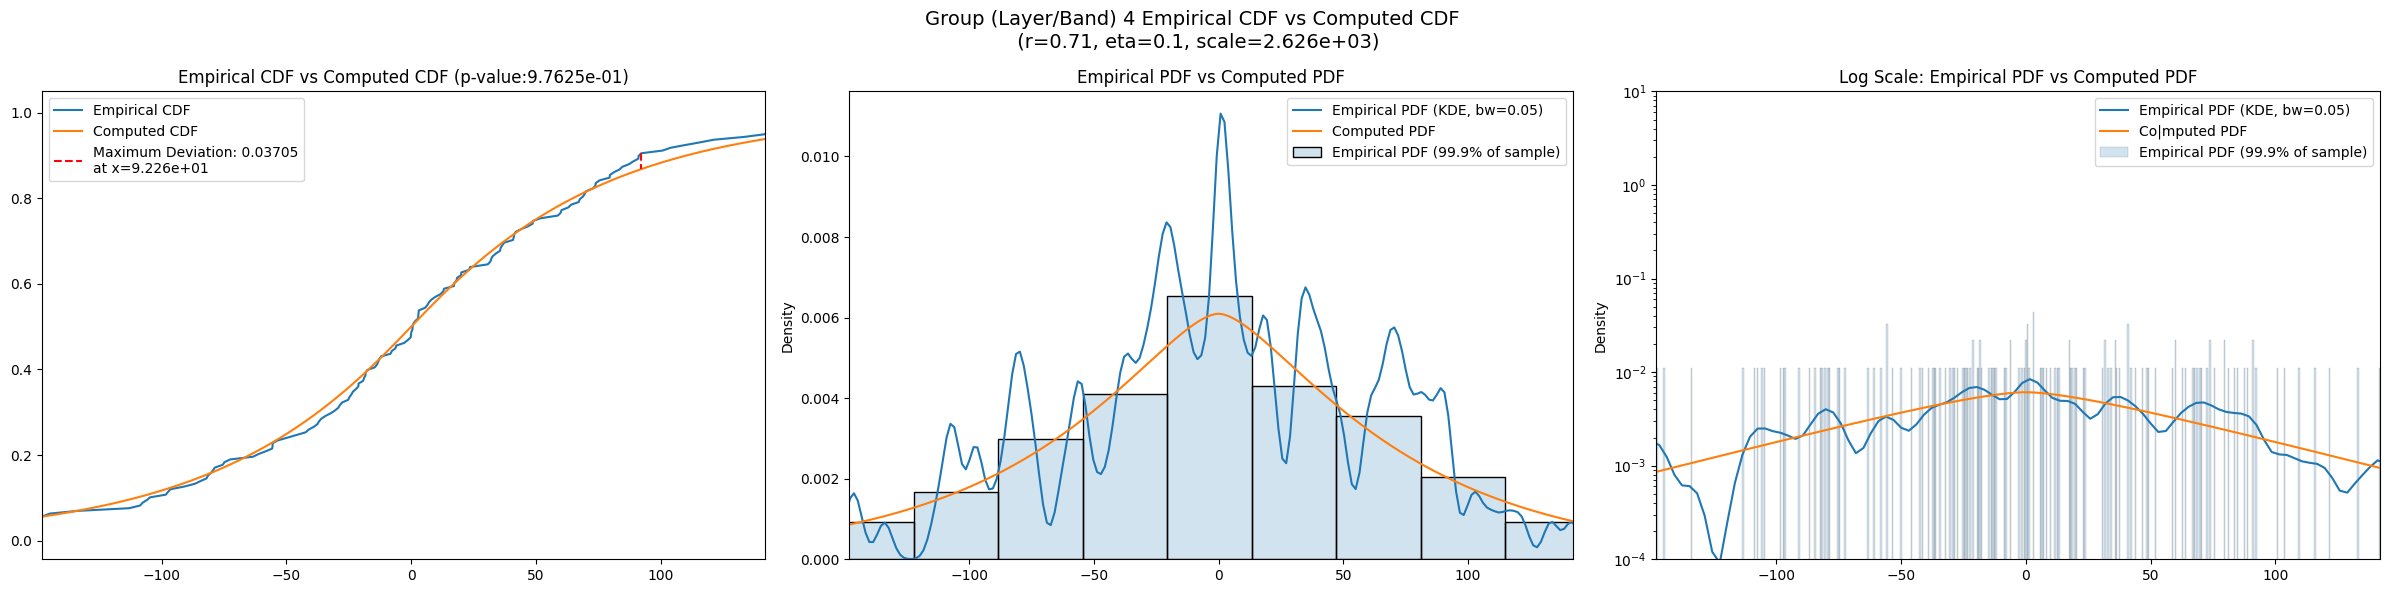

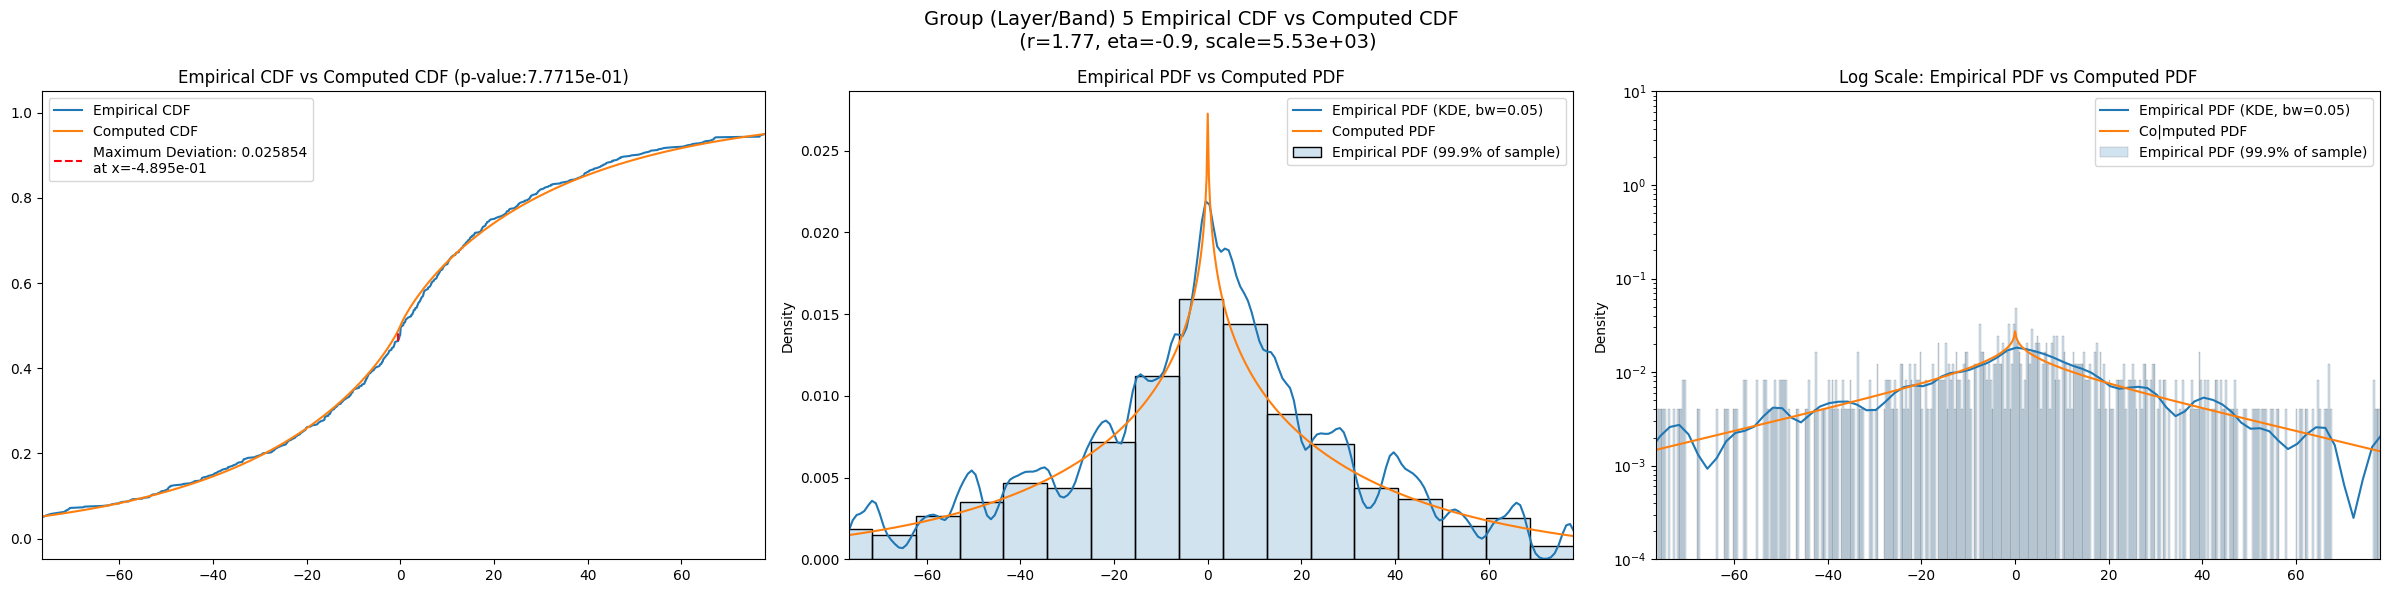

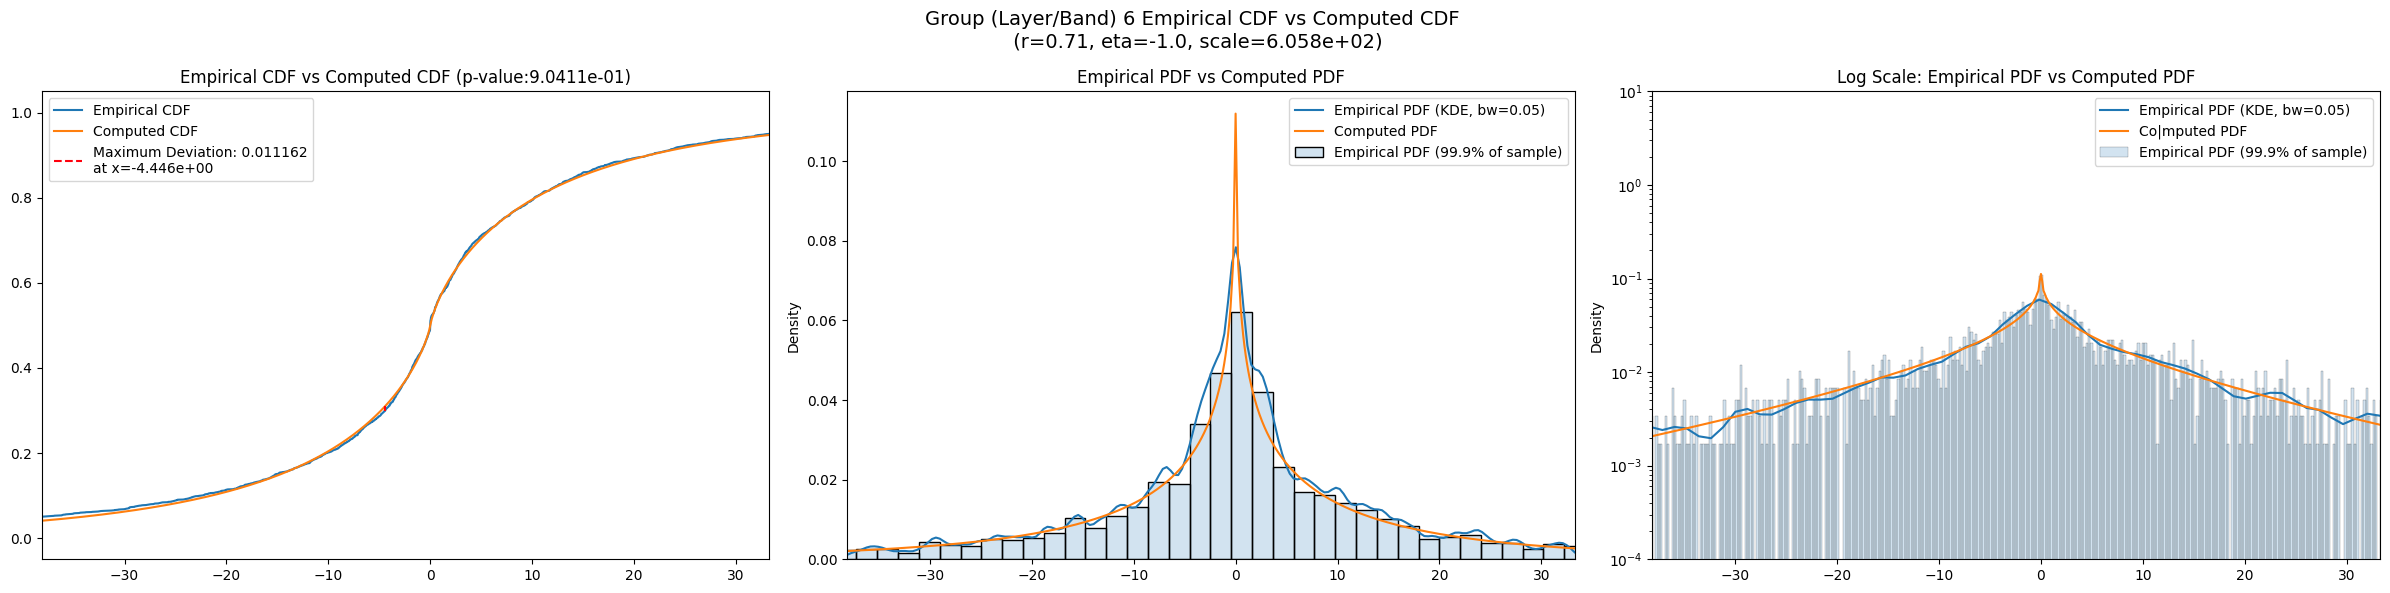

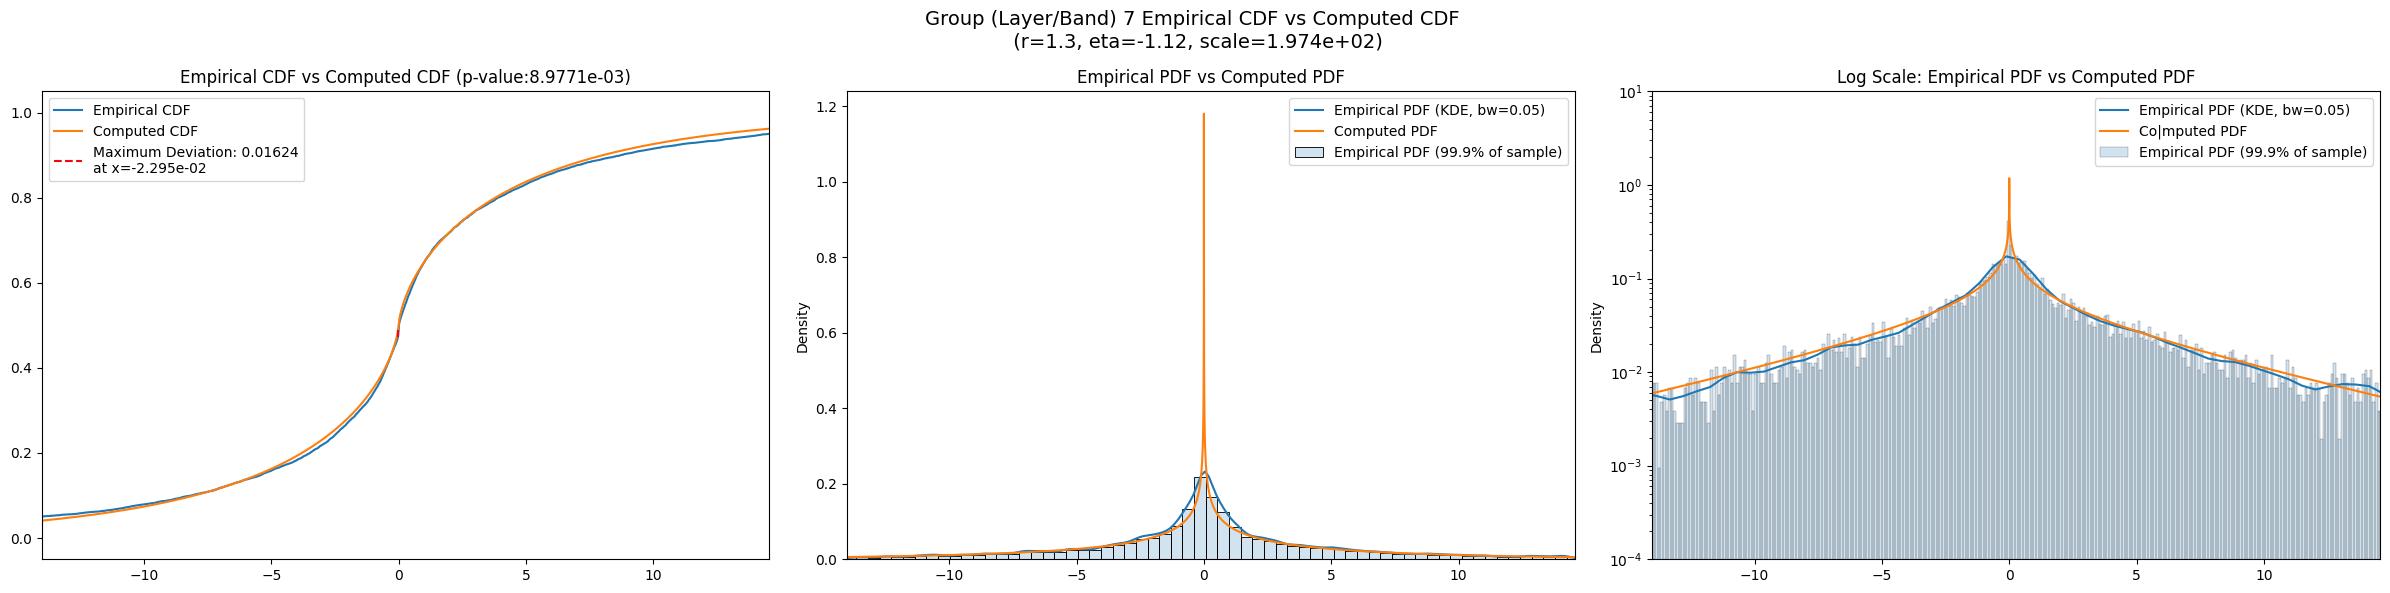

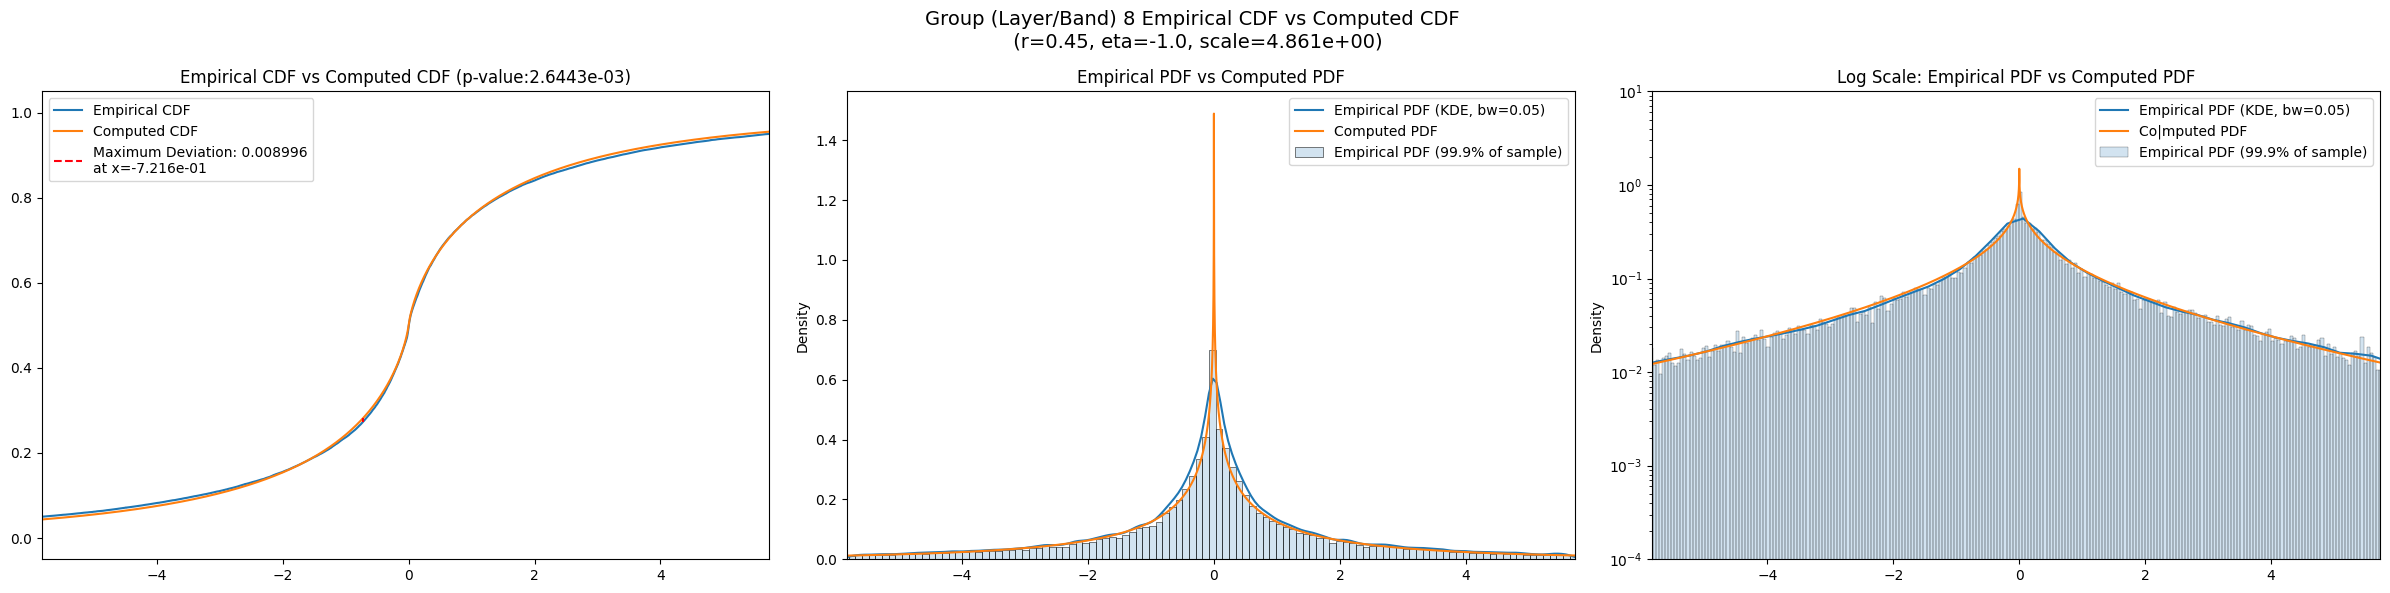

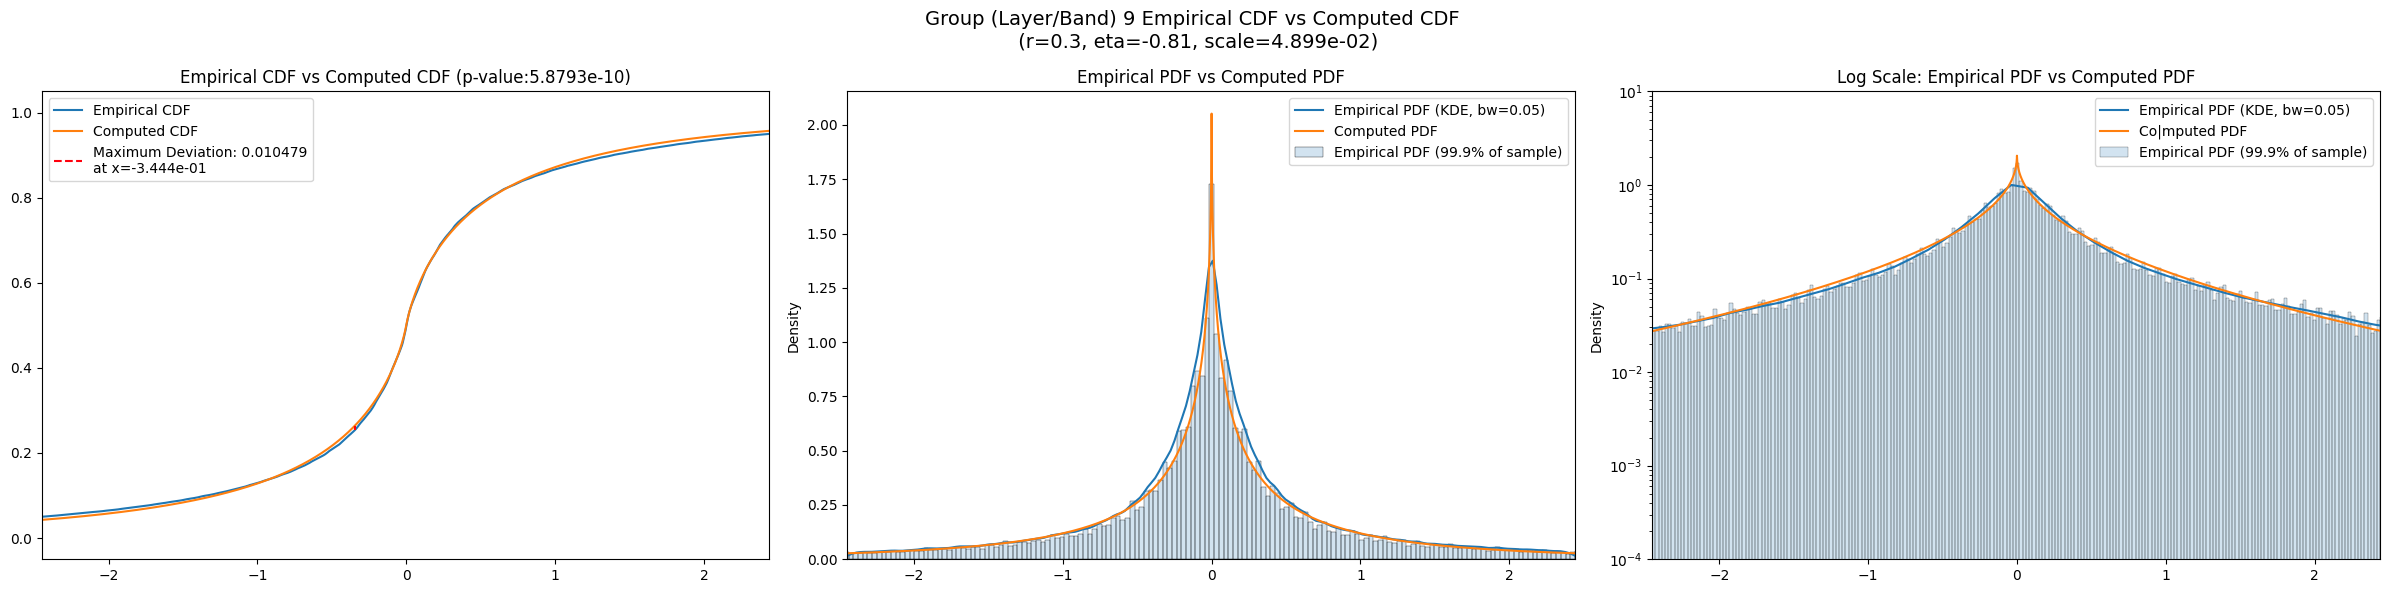

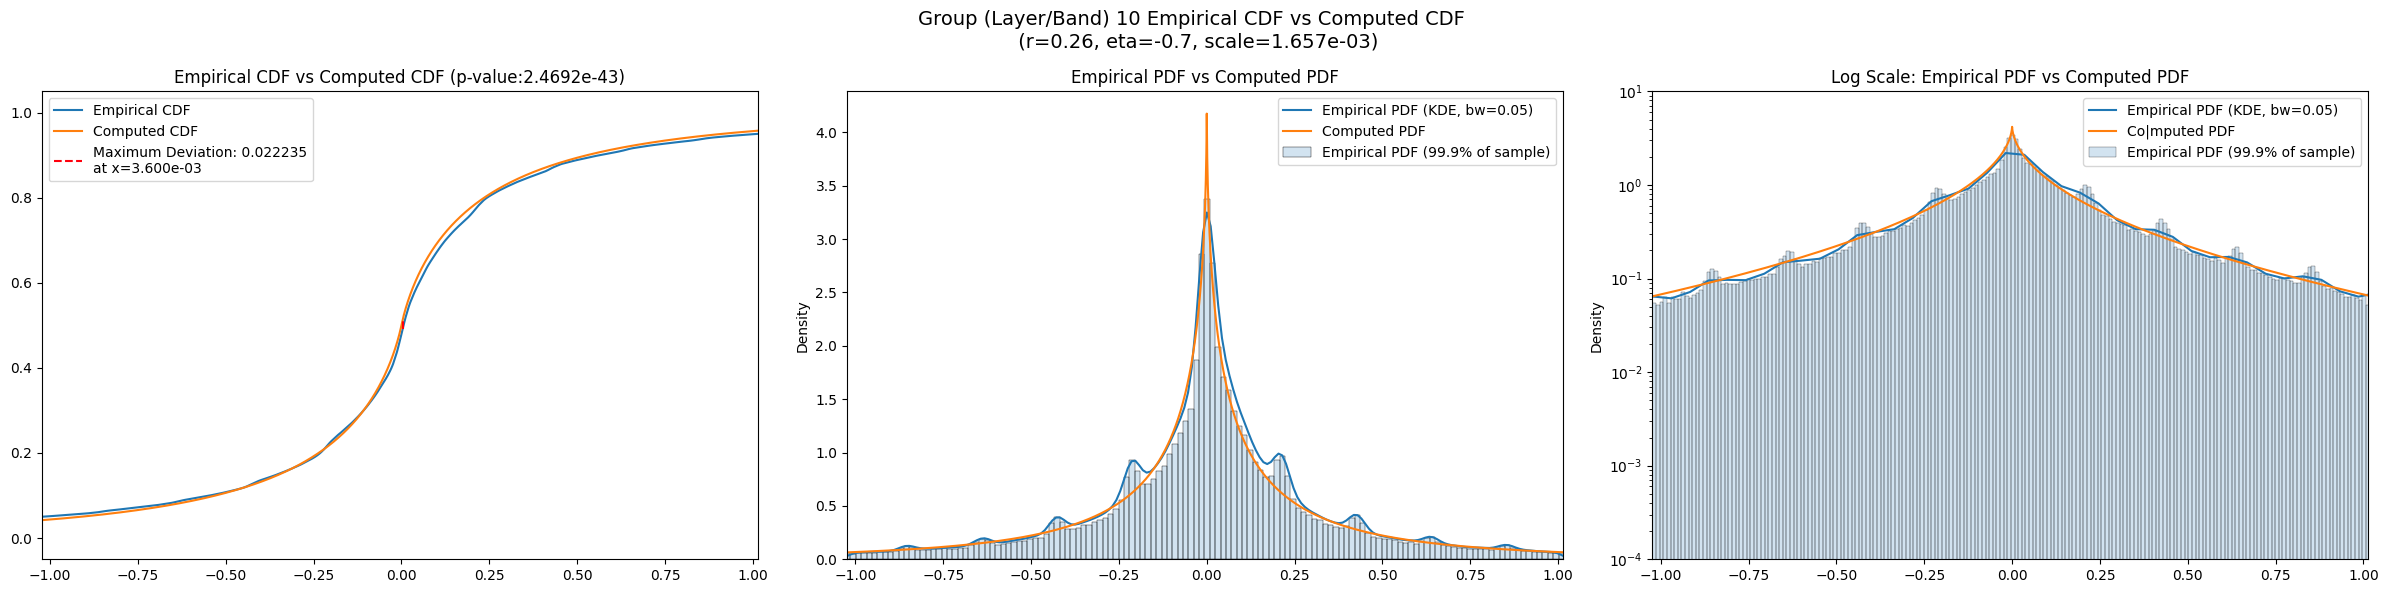

In [25]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [26]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [27]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      104440.140000  17156.541000  208108.020000  -0.478935   -1.727989   
3       44569.270000  16227.428000   89167.160000   2.537533   -1.361574   
4        9230.203000   5827.001500   13169.517000   1.865906    0.593092   
5        2238.107000   1763.183700    2774.085400   2.928785    1.469262   
6         493.924320    427.896880     565.842830   5.546187    4.264880   
7          86.401290     79.868540      93.249466   7.055166    6.091057   
8          15.715902     14.399879      17.106565   9.402432    8.193854   
9           2.729351      2.488192       2.983231  10.534738    8.633498   
10          0.528171      0.476836       0.583170  13.486254   10.583313   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.339415           10.0             0.215500       10.0         20.0   
3        5.529101           40.0             0.123932        0.2          7.1   
4        3.347688          160.0             0.032590        0.7          0.1   
5        4.476616          640.0             0.025770        1.8         -0.9   
6        6.883670         2560.0             0.011079        0.7         -1.0   
7        8.109751        10240.0             0.016825        0.9         -1.1   
8       10.719175        40960.0             0.011232        0.5         -1.0   
9       13.045739       163840.0             0.011038        0.3         -0.8   
10      17.842747       655360.0             0.022639        0.3         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      531.332000              0.209409          6.994490e-01   
3      ...      182.889000              0.119427          5.769540e-01   
4      ...       74.637400              0.042660          9.207320e-01   
5      ...       35.201300              0.050950          6.964560e-02   
6      ...       12.688800              0.065677          4.810980e-10   
7      ...        4.532510              0.074104          2.389780e-49   
8      ...        1.753170              0.073270         1.134340e-191   
9      ...        0.733242              0.072838          0.000000e+00   
10     ...        0.308348              0.069484          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         557.201000             0.211120         6.903260e-01  454.312000   
3         164.617000             0.128891         4.803470e-01  142.137000   
4          71.378300             0.037276         9.733470e-01   60.442200   
5          29.683400             0.029322         6.300790e-01   24.712100   
6          11.104200             0.038768         8.849710e-04    8.863140   
7           3.895710             0.047988         6.236020e-21    3.072170   
8           1.520950             0.046895         1.022170e-78    1.203360   
9           0.644095             0.045825        2.027320e-299    0.505353   
10          0.254855             0.047765         0.000000e+00    0.199377   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.209751   6.976290e-01          6.668236e-01  
3           0.127797   4.911390e-01          5.316356e-01  
4           0.033447   9.914340e-01          9.948016e-01  
5           0.033145   4.729390e-01          7.800308e-01  
6           0.039006   8.048750e-04          9.171624e-01  
7           0.050362   5.187970e-23          9.276234e-03  
8           0.048398   8.104220e-84          3.685528e-03  
9           0.045527  1.548380e-295          2.446609e-15  
10        

## Results

In [28]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [29]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.215500                 0.409246          0.215500   
3                 0.123932                 0.210115          0.123784   
4                 0.032590                 0.106268          0.032107   
5                 0.025770                 0.053416          0.025742   
6                 0.011079                 0.026776          0.010915   
7                 0.016825                 0.013405          0.016181   
8                 0.011232                 0.006706          0.008763   
9                 0.011038                 0.003354          0.010236   
10                0.022639                 0.001677          0.022138   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.209409             0.211120       0.209751  
3                  0.119427             0.128891       0.127797  
4                  0.042660             0.037276       0.033447  
5                  0.050950             0.029322       0.033145  
6                  0.065677             0.038768       0.039006  
7                  0.074104             0.047988       0.050362  
8                  0.073270             0.046895       0.048398  
9                  0.072838             0.045825       0.045527  
10                 0.069484             0.047765       0.050367

In [30]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2           104440.140000          0.215500   10.00     20.00  98908.789681   
3            44569.269531          0.123784    0.19      7.50      0.000054   
4             9230.203125          0.032107    0.71      0.10   2625.994177   
5             2238.106934          0.025742    1.77     -0.90   5529.568379   
6              493.924316          0.010915    0.71     -1.00    605.758394   
7               62.153954          0.016181    1.30     -1.12    197.397408   
8               14.262267          0.008763    0.45     -1.00      4.861448   
9                2.729351          0.010236    0.30     -0.81      0.048990   
10               0.480753          0.022138    0.26     -0.70      0.001657   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                     75.0  
8                     50.0  
9                      0.0  
10                    75.0

In [31]:
eng.quit()